In [6]:
import torch
import torch.nn as nn
import pandas as pd
from chessEngine import ChessEncoder, MLPEngine
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import LambdaLR
from print_color import print
import wandb
import torch._dynamo
torch._dynamo.config.suppress_errors = True
torch.set_float32_matmul_precision('high')
from tqdm import trange

# Preprocessing

In [2]:
df = pd.read_csv('data/chessDataFinal.csv')[:1000000]
df

,fen,score
0,5rk1/pb1pnppp/3Q2q1/b3P3/2B5/5N2/P4PPP/R4RK1 w...,+276
1,b1r5/3nk2p/R7/4p1p1/1PN1P3/2BP4/7P/6K1 w - - 8 59,+451
2,5k2/5p2/3p2p1/2p4q/p1P5/P3P2K/5QP1/3R4 w - - 1 34,-317
3,r5k1/pp2qrpp/4Pp2/2bp4/2p2P2/2Q5/PP4KP/nNB1R3 ...,-594
4,2nk3r/2p3pp/3p1p2/P2Q4/3P4/q4N2/4RKP1/8 w - - ...,+281
...,...,...
999995,2r1k3/1p3pb1/p5R1/7p/4PN1P/B4P2/1Pr3P1/5K2 w -...,+512
999996,rnbqkb1r/pp3ppp/3ppn2/2p5/4P3/2NP2P1/PPP2P1P/R...,+53
999997,3r3k/1b1r3p/p4pp1/1pqnp3/4B3/1QPR1N2/5PPP/3R2K...,-413
999998,4r1k1/R7/5Q2/1p4pp/5N2/1P5P/1P4PK/4r3 b - - 2 41,#+5


In [3]:
encoder_object = ChessEncoder()

In [8]:
fen_encodings = []
for i in trange(len(df['fen'])):
    encoded_fen = encoder_object.encode_fen(df['fen'][i])
    fen_encodings.append(encoded_fen)

100%|██████████| 1000000/1000000 [00:19<00:00, 51861.59it/s]


In [9]:
X_train = torch.tensor(fen_encodings, dtype=torch.int32)

In [10]:
score_encodings = []
for y_i in df['score']:
    # print(y_i)
    encoded_score = encoder_object.encode_score(str(y_i))
    score_encodings.append(encoded_score)
y_train = torch.tensor(score_encodings, dtype=torch.float32)

In [11]:
X_train.shape, y_train.shape

(torch.Size([1000000, 200]), torch.Size([1000000]))

# Helper Functions

In [12]:
val_split = 10000
test_split = 10000

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [14]:
def get_batch(X, Y, bs):
    
    assert isinstance(X, torch.Tensor)
    assert isinstance(Y, torch.Tensor)

    batch = torch.randint(0, len(X), (bs,))
    x = X[batch].to(device)
    y = Y[batch].to(device).to(torch.float32)
    return x, y
# b = get_batch(X, y, 64)

In [15]:
X_val = X_train[:val_split].to(device)
y_val = y_train[:val_split].to(device)
X_test = X_train[val_split:val_split+test_split].to(device)
y_test = y_train[val_split:val_split+test_split].to(device)
X_train = X_train[val_split+test_split:]
y_train = y_train[val_split+test_split:]

# Training

In [16]:
# hyperparameters
lr = 5e-2
num_steps = 500
warmup_steps = 30
bs_train = 10000
bs_validation = len(X_val) # don't change this
if bs_train > len(X_train): bs_train = len(X_train)
if bs_validation > len(X_train): bs_validation = len(X_train)

In [17]:
len(X_train), len(X_val)

(980000, 10000)

In [ ]:
model = MLPEngine(embedding_dim=64, bs_train = bs_train, bs_eval=bs_validation).to(device)
loss_category = nn.MSELoss()
optimiser = torch.optim.AdamW(
            model.parameters(), 
            lr = lr,
            betas=(0.9, 0.999),
            eps=1e-3,
            weight_decay=1e-5)

# Define warm-up and decay
def lr_lambda(epoch):
    if epoch < warmup_steps:  
        return epoch / warmup_steps
    else:  # Exponential decay after warm-up
        return 0.99 ** (epoch - warmup_steps)

scheduler = LambdaLR(optimiser, lr_lambda)
model.compile()
train_history = {}
val_history = {}
start_step = 0

In [ ]:
# if e
# run = wandb.init(project="chessAI")
# # run.config = {"epochs": num_steps, "learning_rate": lr}
# wandb.watch(model)

In [ ]:
model.train()
for step_i in range(1, num_steps+1):
    tot_step = step_i + start_step
    optimiser.zero_grad()
    x_batch, y_batch = get_batch(X_train, y_train, bs_train) 
    # print(x_batch.shape, y_batch.shape)
    y_pred = model(x_batch).view(bs_train)
    loss = loss_category(y_pred, y_batch)
    train_history[tot_step] = loss.item()
    loss.backward()
    optimiser.step()
    scheduler.step()
    # wandb.log({"Training Loss": loss.item()})
    print(tot_step, ': ',loss.item())

    if tot_step % 100 == 0 or tot_step==1:
        # validation phase
        model.eval()
        y_pred = model(X_val).view(bs_validation)
        # print(X_val.shape, y_pred.shape)
        loss = loss_category(y_pred, y_val)
        val_history[tot_step] = loss.item()
        print(f'{tot_step}: {loss.item()} (Validation)', color='r')
        # wandb.log({"Validation Loss": loss.item()})
        model.train()


start_step += num_steps

1 :  3565025.5
1: 3450075.0 (Validation)
2 :  3543231.5
3 :  3755630.0
4 :  3521963.5
5 :  3670872.75
6 :  3613536.25
7 :  3532493.5
8 :  3577954.5
9 :  3826714.0
10 :  3937446.25
11 :  3586740.25
12 :  3595940.25
13 :  3449314.75
14 :  3989037.75
15 :  3783677.5
16 :  3661800.25
17 :  3574602.75
18 :  3477483.0
19 :  3633660.75
20 :  3872244.0
21 :  3515674.5
22 :  3527269.5
23 :  3675852.0
24 :  3441288.0
25 :  3674442.75
26 :  3429911.0
27 :  3620420.0
28 :  3505831.75
29 :  3659611.75
30 :  3112441.5
31 :  3476035.0
32 :  3559530.75
33 :  3186198.5
34 :  3247568.75
35 :  3519352.0
36 :  3405613.75
37 :  3198896.5
38 :  3501323.75
39 :  3454731.0
40 :  3365242.25
41 :  3324136.5
42 :  3167074.75
43 :  3261635.75
44 :  3165582.75
45 :  3238198.75
46 :  3244239.5
47 :  2884321.0
48 :  3257487.75
49 :  3378149.75
50 :  3000182.75
51 :  3078229.0
52 :  2922228.0
53 :  3144797.75
54 :  3098811.5
55 :  2780365.25
56 :  2658481.0
57 :  3064470.75
58 :  3074932.75
59 :  3072528.75
60 :  308

In [ ]:
torch.save(model.state_dict(), 'saves/model3.pt')

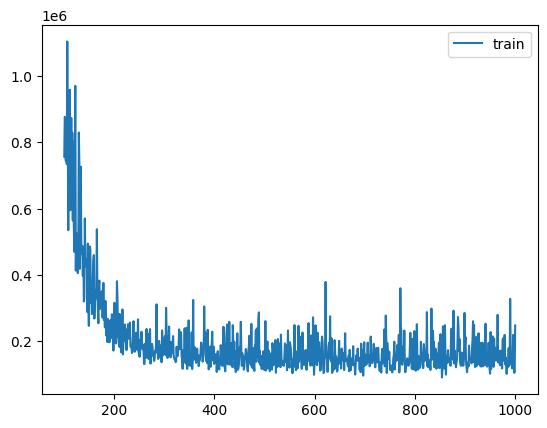

In [ ]:
plt.plot(list(train_history.keys())[100:], list(train_history.values())[100:], label='train')
# plt.plot(val_history.keys(), val_history.values(), label='validation')
plt.legend()
plt.show()

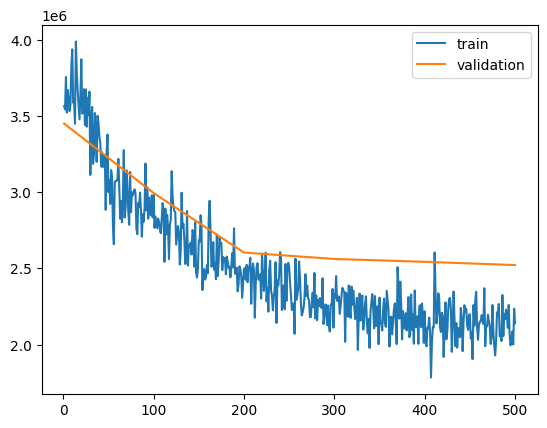

In [ ]:
plt.plot(list(train_history.keys()), list(train_history.values()), label='train')
plt.plot(val_history.keys(), val_history.values(), label='validation')
plt.legend()
plt.show()

In [ ]:
'''
# My results
At relu, model is stuck around 25k with 3x1000 steps with xavier
AT relu, moedl went to 9k and then exploded at 3x1000 steps with kaiming; then at 14k
At gelu, model is stuck atound 10k

Adam is better than AdamW for this task
'''

'\n# My results\nAt relu, model is stuck around 25k with 3x1000 steps with xavier\nAT relu, moedl went to 9k and then exploded at 3x1000 steps with kaiming; then at 14k\nAt gelu, model is stuck atound 10k\n\nAdam is better than AdamW for this task\n'

# TO DO

- [x] do inference, and run a partially trained model with the GUI intact
- [x] **find a way to fix the fact that our model is giving integer loss
- [x] **Fix the bug in initialisation
- [ ] implement weights and biases or tensorboard 
- [ ] improve the model
  - [x] get a better/ bigger dataset
  - [ ] hyperparameter and architecture
    - [x] better encoding
    - [ ] residual connections
    - [ ] try adamW after tuning b1 and b2
    - [x] increase embedding dim
    - [x] increase neurons in the layers
    - [x] increase layers in the network
    - [x] change loss function (maybe)
    - [ ] try diff learning rate scheduler(trapeziodal)
    - [ ] Add regularisation
      - [ ] l1,l2
      - [x] dropout
    - [x] Better initialisation
    - [x] diff optimisation algorithm

# Note

My model is overfitting. What can i do?
- potential bug in val loss calculation
- regualisation
  - dropout
  - l1, l2
- make the model smaller, length and breadth
- 
- increase dataset, increase variety